In [2]:
#load all Python packages and warning suppressions
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import warnings
import numpy as np
from pprint import pprint


from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#load dataset and describe attributes
filename = 'census_income_dataset.csv'
filepath = os.path.join(r'C:\Users\rlangran\Desktop\UT Data Analytics\Section 5\Capstone',filename)
df = pd.read_csv(filepath)
#make copy of original dataset
dfc = df
#list attributes
colms = df.columns.values.tolist()
#print attributes and information
print(colms)
print(df.info())

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null object
income            48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [4]:
#strip whitespace from all string attributes
cols = (['workclass','education','marital-status', 'occupation', 'relationship','race', 'sex',
         'native-country', 'income'])
for c in cols:
    df[c] = df[c].str.strip()
#print which attributes have the "?" included    
for c in colms:
    print(c," # of ?:",df[c].loc[df[c] == '?'].count())

age  # of ?: 0
workclass  # of ?: 2799
fnlwgt  # of ?: 0
education  # of ?: 0
education-num  # of ?: 0
marital-status  # of ?: 0
occupation  # of ?: 2809
relationship  # of ?: 0
race  # of ?: 0
sex  # of ?: 0
capital-gain  # of ?: 0
capital-loss  # of ?: 0
hours-per-week  # of ?: 0
native-country  # of ?: 857
income  # of ?: 0


In [5]:
#print five number summaries
print(dfc.describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


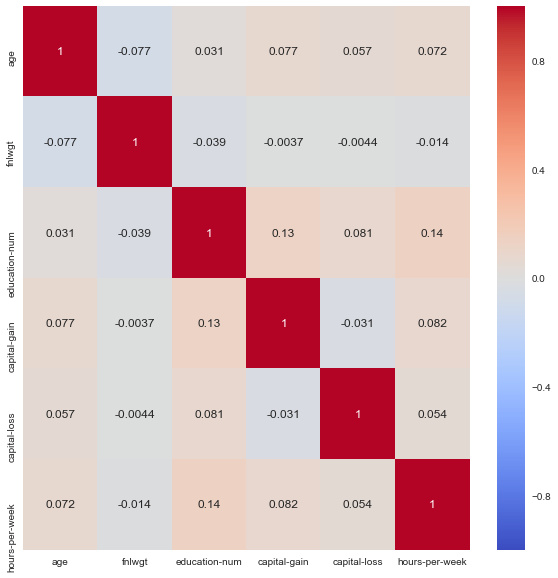

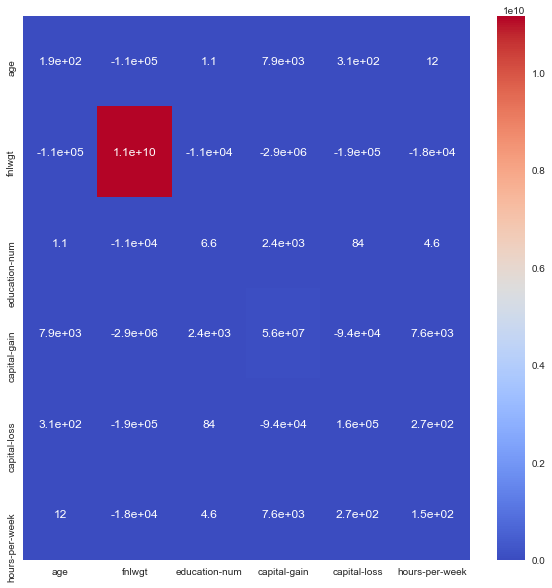

In [6]:
#check correlation and covariance using heatmaps
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
sns.heatmap(dfc.corr(),vmin=-1,cmap='coolwarm',annot=True);

plt.figure(figsize=(10,10))
sns.heatmap(dfc.cov(),vmin=-1,cmap='coolwarm',annot=True);

(array([37155., 11687.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

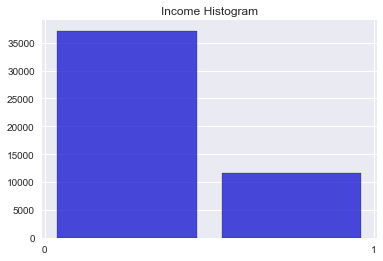

In [7]:
#relabel categories for all string attributes for ease of visualization in histograms
#and for compatibility with RFE functions
#income attribute and histogram
daa = ({'<=50K':'0','>50K':'1'})
dfc['income2'] = dfc['income'].replace(daa)
#income histogram
fig1, ax20 = plt.subplots()
ax20.set_title('Income Histogram')
ax20.hist(dfc['income2'],bins=2,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid') 

(array([2.7990e+03, 1.4320e+03, 3.1360e+03, 2.1000e+01, 1.0000e+01,
        3.3906e+04, 1.9810e+03, 1.6950e+03, 3.8620e+03]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <a list of 9 Patch objects>)

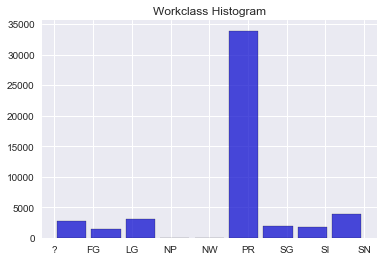

In [8]:
#workclass attribute and histogram
d = ({'State-gov':'SG','Self-emp-not-inc':'SN','Private':'PR','Federal-gov':'FG','Local-gov':'LG',
             'Self-emp-inc':'SI','Without-pay':'NP','Never-worked':'NW'})
d1 = ({'State-gov':'1','Self-emp-not-inc':'2','Private':'3','Federal-gov':'4','Local-gov':'5',
             'Self-emp-inc':'6','Without-pay':'7','Never-worked':'8'})
dfc['workclass2'] = dfc['workclass'].replace(d)
dfc['workclass3'] = dfc['workclass'].replace(d1)
#workclass histogram
fig1, ax1 = plt.subplots()
ax1.set_title('Workclass Histogram')
ax1.hist(dfc['workclass2'],bins=9,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([2799., 1432., 3136.,   21.,   10., 1981., 1695., 3862.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

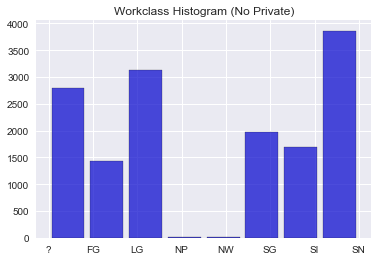

In [9]:
#remove private and create updated histogram
dfca1 = dfc.loc[dfc['workclass2'] != 'PR']
#workclass without private histogram
fig1, ax2 = plt.subplots()
ax2.set_title('Workclass Histogram (No Private)')
ax2.hist(dfca1['workclass2'],bins=8,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([ 1601.,  2061.,   594.,  1794., 15784.,  4614.,  2657.,   834.,
        10878.,  8025.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

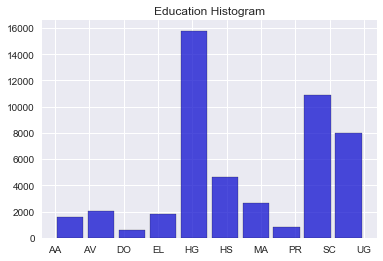

In [10]:
#education attribute and histogram
da = ({'Bachelors':'UG','HS-grad':'HG','11th':'HS','Masters':'MA','9th':'HS','7th-8th':'EL','5th-6th':'EL',
       'Some-college':'SC','Assoc-acdm':'AA','Prof-school':'PR','10th':'HS','12th':'HS','1st-4th':'EL',
       'Preschool':'EL','Assoc-voc':'AV','Doctorate':'DO'})
da1 = ({'Bachelors':'8','HS-grad':'3','11th':'2','Masters':'9','9th':'2','7th-8th':'1','5th-6th':'1',
       'Some-college':'4','Assoc-acdm':'5','Prof-school':'7','10th':'2','12th':'2','1st-4th':'1',
       'Preschool':'1','Assoc-voc':'6','Doctorate':'10'})
dfc['education2'] = dfc['education'].replace(da)
dfc['education3'] = dfc['education'].replace(da1)
#education histogram
fig1, ax4 = plt.subplots()
ax4.set_title('Education Histogram')
ax4.hist(dfc['education2'],bins=10,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([2809., 5611.,   15., 6112., 6086., 1490., 2072., 3022., 4923.,
         242.,  983., 6172., 5504., 2355., 1446.]),
 array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
         4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
         9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
        14.        ]),
 <a list of 15 Patch objects>)

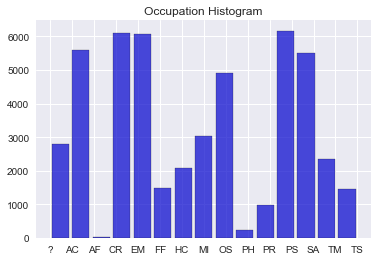

In [11]:
#occupation attribute and histogram
db = ({'Tech-support':'TS','Craft-repair':'CR','Other-service':'OS','Sales':'SA','Exec-managerial':'EM',
       'Prof-specialty':'PS','Handlers-cleaners':'HC','Machine-op-inspct':'MI','Adm-clerical':'AC',
       'Farming-fishing':'FF','Priv-house-serv':'PH','Protective-serv':'PR','Armed-Forces':'AF',
       'Transport-moving':'TM'})    
db1 = ({'Tech-support':'1','Craft-repair':'2','Other-service':'3','Sales':'4','Exec-managerial':'5',
       'Prof-specialty':'6','Handlers-cleaners':'7','Machine-op-inspct':'8','Adm-clerical':'9',
       'Farming-fishing':'10','Priv-house-serv':'11','Protective-serv':'12','Armed-Forces':'13',
       'Transport-moving':'14'})
dfc['occupation2'] = dfc['occupation'].replace(db)
dfc['occupation3'] = dfc['occupation'].replace(db1)
#occupation histogram
fig1, ax5 = plt.subplots()
ax5.set_title('Occupation Histogram')
ax5.hist(dfc['occupation2'],bins=15,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([19716., 12583.,  7581.,  1506.,  5125.,  2331.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

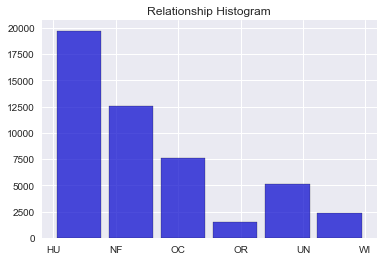

In [12]:
#relationship attribute and histogram
dc = ({'Wife':'WI','Own-child':'OC','Husband':'HU','Not-in-family':'NF','Other-relative':'OR',
       'Unmarried':'UN'})
dc1 = ({'Wife':'1','Own-child':'2','Husband':'3','Not-in-family':'4','Other-relative':'5',
       'Unmarried':'6'})
dfc['relationship2'] = dfc['relationship'].replace(dc)
dfc['relationship3'] = dfc['relationship'].replace(dc1)
#relationship histogram
fig1, ax6 = plt.subplots()
ax6.set_title('Relationship Histogram')
ax6.hist(dfc['relationship2'],bins=6,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([ 6633., 22379.,    37.,   628., 16117.,  1530.,  1518.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

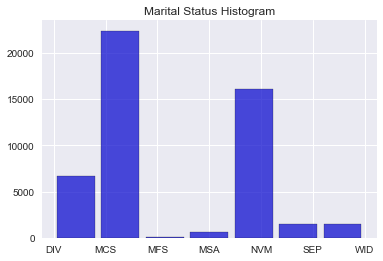

In [13]:
#marital status attribute and histogram
dc1 = ({'Married-civ-spouse':'MCS','Divorced':'DIV','Never-married':'NVM','Separated':'SEP','Widowed':'WID',
        'Married-spouse-absent':'MSA','Married-AF-spouse':'MFS'})
dc11 = ({'Married-civ-spouse':'1','Divorced':'2','Never-married':'3','Separated':'4','Widowed':'5',
        'Married-spouse-absent':'6','Married-AF-spouse':'7'})
dfc['marital-status2'] = dfc['marital-status'].replace(dc1)
dfc['marital-status3'] = dfc['marital-status'].replace(dc11)
#marital status histogram
fig1, ax61 = plt.subplots()
ax61.set_title('Marital Status Histogram')
ax61.hist(dfc['marital-status2'],bins=7,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([16192., 32650.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

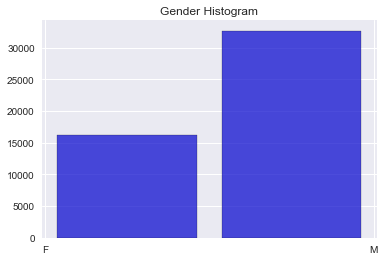

In [14]:
#sex attribute and histogram
dc2 = ({'Male':'M','Female':'F'})
dc21 = ({'Male':'1','Female':'2'})
dfc['sex2'] = dfc['sex'].replace(dc2)
dfc['sex3'] = dfc['sex'].replace(dc21)
#gender histogram
fig1, ax62 = plt.subplots()
ax62.set_title('Gender Histogram')
ax62.hist(dfc['sex2'],bins=2,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([  470.,  1519.,  4685.,   406., 41762.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <a list of 5 Patch objects>)

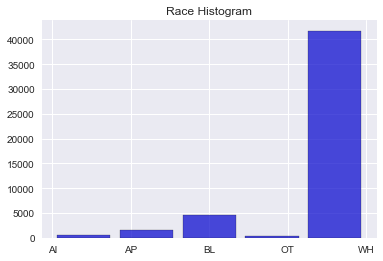

In [15]:
#race attribute and histogram
dd = ({'White':'WH','Asian-Pac-Islander':'AP','Amer-Indian-Eskimo':'AI','Other':'OT','Black':'BL'})
dd1 = ({'White':'1','Asian-Pac-Islander':'2','Amer-Indian-Eskimo':'3','Other':'4','Black':'5'})
dfc['race2'] = dfc['race'].replace(dd)
dfc['race3'] = dfc['race'].replace(dd1)
#race histogram
fig1, ax7 = plt.subplots()
ax7.set_title('Race Histogram')
ax7.hist(dfc['race2'],bins=5,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([8.5700e+02, 1.8200e+02, 2.8000e+01, 1.2200e+02, 8.5000e+01,
        1.3800e+02, 1.0300e+02, 1.2700e+02, 4.5000e+01, 1.5500e+02,
        3.8000e+01, 2.0600e+02, 4.9000e+01, 8.8000e+01, 1.9000e+01,
        3.0000e+01, 1.0000e+00, 2.0000e+01, 7.5000e+01, 3.7000e+01,
        0.0000e+00, 1.5100e+02, 5.9000e+01, 1.0500e+02, 1.0600e+02,
        9.2000e+01, 2.3000e+01, 9.5100e+02, 4.9000e+01, 2.3000e+01,
        2.9500e+02, 8.7000e+01, 2.3000e+02, 6.7000e+01, 2.1000e+01,
        1.1500e+02, 2.7000e+01, 3.0000e+01, 6.5000e+01, 4.3832e+04,
        8.6000e+01, 2.3000e+01]),
 array([ 0.        ,  0.95238095,  1.9047619 ,  2.85714286,  3.80952381,
         4.76190476,  5.71428571,  6.66666667,  7.61904762,  8.57142857,
         9.52380952, 10.47619048, 11.42857143, 12.38095238, 13.33333333,
        14.28571429, 15.23809524, 16.19047619, 17.14285714, 18.0952381 ,
        19.04761905, 20.        , 20.95238095, 21.9047619 , 22.85714286,
        23.80952381, 24.76190476, 25.71428571, 26.6666666

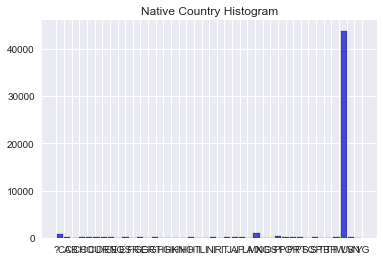

In [16]:
#native country attribute and histogram
de = ({'United-States':'US','Cambodia':'CB','England':'EN','Puerto-Rico':'PR','Canada':'CA',
       'Germany':'GE','Outlying-US(Guam-USVI-etc)':'OS','India':'IN','Japan':'JP',
       'Greece':'GR','South':'SP','China':'CH','Cuba':'CU','Iran':'IR','Honduras':'HO','Philippines':'PI',
       'Italy':'IT','Poland':'PO','Jamaica':'JA','Vietnam':'VN','Ireland':'IL','France':'FR','Dominican-Republic':'DR',
       'Mexico':'MX','Yugoslavia':'YG','El-Salvador':'ES','Trinadad&Tobago':'TB','Peru':'PR','Hong':'HK',
       'Holand-Netherlands':'HN','Laos':'LA','Ecuador':'EQ','Taiwan':'TW','Haiti':'HT','Columbia':'CO','Hungary':'HG',
       'Thailand':'TH','Nicaragua':'NG','Scotland':'SC','Guatemala':'GT','Portugal':'PT'})
de1 = ({'United-States':'1','Cambodia':'2','England':'3','Puerto-Rico':'4','Canada':'5',
       'Germany':'6','Outlying-US(Guam-USVI-etc)':'7','India':'8','Japan':'9',
       'Greece':'10','South':'11','China':'12','Cuba':'13','Iran':'14','Honduras':'15','Philippines':'16',
       'Italy':'17','Poland':'18','Jamaica':'19','Vietnam':'20','Ireland':'21','France':'22','Dominican-Republic':'23',
       'Mexico':'24','Yugoslavia':'25','El-Salvador':'26','Trinadad&Tobago':'27','Peru':'28','Hong':'29',
       'Holand-Netherlands':'30','Laos':'31','Ecuador':'32','Taiwan':'33','Haiti':'34','Columbia':'35','Hungary':'36',
       'Thailand':'37','Nicaragua':'38','Scotland':'39','Guatemala':'40','Portugal':'41'})
dfc['native-country2'] = dfc['native-country'].replace(de)
dfc['native-country3'] = dfc['native-country'].replace(de1)
#native country histogram
fig1, ax8 = plt.subplots()
ax8.set_title('Native Country Histogram')
ax8.hist(dfc['native-country2'],bins=42,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

(array([857., 182.,  28., 122.,  85., 138., 103., 127.,  45., 155.,  38.,
        206.,  49.,  88.,  19.,  30.,   1.,  20.,  75.,  37.,   0., 151.,
         59., 105., 106.,  92.,  23., 951.,  49.,  23., 295.,  87., 230.,
         67.,  21., 115.,  27.,  30.,  65.,  86.,  23.]),
 array([ 0.        ,  0.95121951,  1.90243902,  2.85365854,  3.80487805,
         4.75609756,  5.70731707,  6.65853659,  7.6097561 ,  8.56097561,
         9.51219512, 10.46341463, 11.41463415, 12.36585366, 13.31707317,
        14.26829268, 15.2195122 , 16.17073171, 17.12195122, 18.07317073,
        19.02439024, 19.97560976, 20.92682927, 21.87804878, 22.82926829,
        23.7804878 , 24.73170732, 25.68292683, 26.63414634, 27.58536585,
        28.53658537, 29.48780488, 30.43902439, 31.3902439 , 32.34146341,
        33.29268293, 34.24390244, 35.19512195, 36.14634146, 37.09756098,
        38.04878049, 39.        ]),
 <a list of 41 Patch objects>)

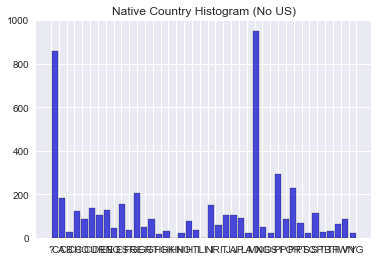

In [17]:
#native country without US
dfca2 = dfc.loc[dfc['native-country2'] != 'US']
fig1, ax9 = plt.subplots()
ax9.set_title('Native Country Histogram (No US)')
ax9.hist(dfca2['native-country2'],bins=41,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

# of  US : 43832
# of  CU : 138
# of  JA : 106
# of  IN : 151
# of  ? : 857
# of  MX : 951
# of  SP : 115
# of  PR : 230
# of  HO : 20
# of  EN : 127
# of  CA : 182
# of  GE : 206
# of  IR : 59
# of  PI : 295
# of  IT : 105
# of  PO : 87
# of  CO : 85
# of  CB : 28
# of  TH : 30
# of  EQ : 45
# of  LA : 23
# of  TW : 65
# of  HT : 75
# of  PT : 67
# of  DR : 103
# of  ES : 155
# of  FR : 38
# of  GT : 88
# of  CH : 122
# of  JP : 92
# of  YG : 23
# of  OS : 23
# of  SC : 21
# of  TB : 27
# of  GR : 49
# of  NG : 49
# of  VN : 86
# of  HK : 30
# of  IL : 37
# of  HG : 19
# of  HN : 1
# of  US : 43855
# of  NA : 2078
# of  AP : 1096
# of  ? : 857
# of  EU : 780
# of  SA : 176


(array([  857.,  1096.,   780.,  2078.,   176., 43855.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

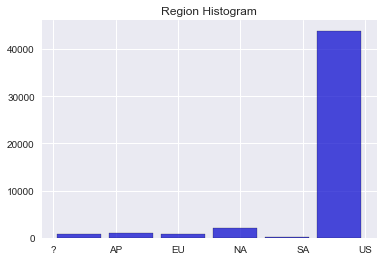

In [20]:
#count number of instances in each native country category
names = dfc['native-country2'].unique()
namess = names.tolist() 
for n in namess:
    print("# of ",n,":",dfc['native-country2'].loc[dfc['native-country2'] == n].count())
#create regions
df = ({'United-States':'US','Cambodia':'AP','England':'EU','Puerto-Rico':'NA','Canada':'NA',
       'Germany':'EU','Outlying-US(Guam-USVI-etc)':'US','India':'AP','Japan':'AP',
       'Greece':'EU','South':'AP','China':'AP','Cuba':'NA','Iran':'AP','Honduras':'NA','Philippines':'AP',
       'Italy':'EU','Poland':'EU','Jamaica':'NA','Vietnam':'AP','Ireland':'EU','France':'EU','Dominican-Republic':'NA',
       'Mexico':'NA','Yugoslavia':'EU','El-Salvador':'NA','Trinadad&Tobago':'NA','Peru':'SA','Hong':'AP',
       'Holand-Netherlands':'EU','Laos':'AP','Ecuador':'SA','Taiwan':'AP','Haiti':'NA','Columbia':'SA','Hungary':'EU',
       'Thailand':'AP','Nicaragua':'NA','Scotland':'EU','Guatemala':'NA','Portugal':'EU'})
dfc['region'] = dfc['native-country'].replace(df)
#count number of instances in each region category
namest = dfc['region'].unique()
namesst = namest.tolist()
for n in namesst:
    print("# of ",n,":",dfc['region'].loc[dfc['region'] == n].count())
#region histogram
fig1, ax91 = plt.subplots()
ax91.set_title('Region Histogram')
ax91.hist(dfc['region'],bins=6,color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k",align='mid')

{'boxes': [<matplotlib.lines.Line2D at 0x141a8784a58>],
 'caps': [<matplotlib.lines.Line2D at 0x141a878d550>,
 'fliers': [<matplotlib.lines.Line2D at 0x141a87932b0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x141a878de10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x141a8784be0>,
  <matplotlib.lines.Line2D at 0x141a878d0f0>]}

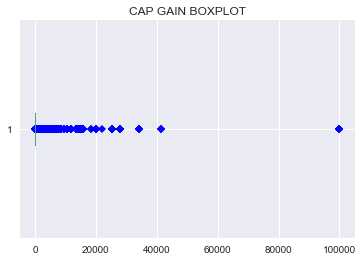

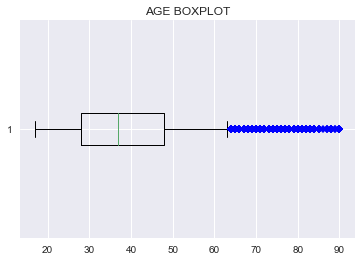

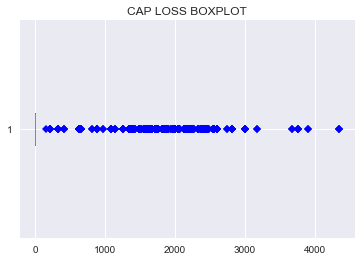

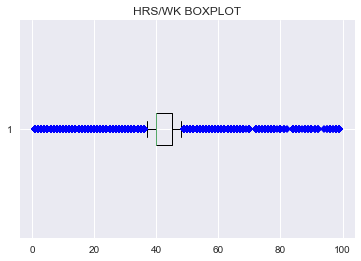

In [21]:
#review box plots of certain continuous data
#capital gain boxplot
blue_diamond = dict(markerfacecolor='b', marker='D')
fig1, ax10 = plt.subplots()
ax10.set_title('CAP GAIN BOXPLOT')
ax10.boxplot(dfc['capital-gain'], flierprops=blue_diamond, vert=False, whis=0.75)
#age boxplot
fig1, ax11 = plt.subplots()
ax11.set_title('AGE BOXPLOT')
ax11.boxplot(dfc['age'], flierprops=blue_diamond, vert=False, whis=0.75)
#capital loss boxplot
fig1, ax12 = plt.subplots()
ax12.set_title('CAP LOSS BOXPLOT')
ax12.boxplot(dfc['capital-loss'], flierprops=blue_diamond, vert=False, whis=0.75)
#hours per week boxplot
fig1, ax13 = plt.subplots()
ax13.set_title('HRS/WK BOXPLOT')
ax13.boxplot(dfc['hours-per-week'], flierprops=blue_diamond, vert=False, whis=0.75)

In [22]:
#select feature dataset for scaling
dffeat = (dfc[['capital-gain','capital-loss','hours-per-week']])
#feature scaling
#min-max method
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1))
x = dffeat.values
x_after_min_max_scaler = min_max_scaler.fit_transform(x) 
dfminmax = pd.DataFrame(x_after_min_max_scaler, columns=['capital-gain_s','capital-loss_s','hours-per-week_s'])

In [23]:
#create age bins
labels = ['1','2','3','4','5']
dfc['age_bin'] = pd.cut(dfc['age'], bins=5,labels=labels)

In [24]:
#concatenate dataframes
dfd = (pd.concat([dfc['capital-gain'],dfc['age'],dfc['hours-per-week'],dfc['capital-loss'],
                  dfc['workclass'],dfc['occupation'],dfc['native-country'],    
                  dfc['age_bin'],
                  dfc['workclass3'],dfc['education3'],dfc['marital-status3'],
                  dfc['occupation3'], dfc['relationship3'],dfc['race3'],dfc['sex3'],dfc['native-country3'],
                  dfminmax,dfc['income2']], axis=1, sort='False'))

In [25]:
#remove all records that contain a "?"
dfe = dfd.loc[dfd['workclass'] != '?']
dff = dfe.loc[dfe['occupation'] != '?']
dfg = dff.loc[dff['native-country'] != '?']
#print of record removal
print("# of ? removed from workclass: ",str(len(dfd)-len(dfe)))
print("# of ? removed from occupation: ",str(len(dfe)-len(dff)))
print("# of ? removed from native-country: ",str(len(dff)-len(dfg)))
#print final count of "?"
colss = dfg.columns.values.tolist()
for c in colss:
    print(c," # of ?:",dfg[c].loc[dfg[c] == '?'].count())

# of ? removed from workclass:  2799
# of ? removed from occupation:  10
# of ? removed from native-country:  811
capital-gain  # of ?: 0
age  # of ?: 0
hours-per-week  # of ?: 0
capital-loss  # of ?: 0
workclass  # of ?: 0
occupation  # of ?: 0
native-country  # of ?: 0
age_bin  # of ?: 0
workclass3  # of ?: 0
education3  # of ?: 0
marital-status3  # of ?: 0
occupation3  # of ?: 0
relationship3  # of ?: 0
race3  # of ?: 0
sex3  # of ?: 0
native-country3  # of ?: 0
capital-gain_s  # of ?: 0
capital-loss_s  # of ?: 0
hours-per-week_s  # of ?: 0
income2  # of ?: 0


In [26]:
#removal all outliers
dfh = dfg[dfg['capital-gain']<=50000]
dfi = dfh[dfh['capital-loss']<=2500]
dfj = dfi[dfi['age']<=80]
dffinal = dfj[dfj['hours-per-week']<=80]
#print of record removal
print("# of capital-gain outliers removed: ",str(len(dfg)-len(dfh)))
print("# of capital-loss outliers removed: ",str(len(dfh)-len(dfi)))
print("# of age outliers removed: ",str(len(dfi)-len(dfj)))
print("# of hours-per-week outliers removed: ",str(len(dfj)-len(dffinal)))

# of capital-gain outliers removed:  229
# of capital-loss outliers removed:  56
# of age outliers removed:  113
# of hours-per-week outliers removed:  291


In [27]:
#create feature sets for train test
x = dffinal.iloc[:,7:-1]
y = dffinal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(x, y.values.ravel(),test_size=0.20,random_state=42)

In [30]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),scoring='accuracy')
rfecv.fit(X_train, y_train)
#print feature recommendations
print("Optimal number of features : %d" % rfecv.n_features_)
print("Support Level of features : ",rfecv.support_)
print("Ranking of features : ",rfecv.ranking_)
#create recursive feature eliminator that scores features by mean squared errors
ols = linear_model.LinearRegression()
rfecv = RFECV(estimator=ols, step=1, scoring='neg_mean_squared_error')
#fit recursive feature eliminator 
rfecv.fit(X_train, y_train)
#recursive feature elimination
rfecv.transform(X_train)
#summarize the selection of the attributes
print(rfecv.support_)
print(rfecv.ranking_)
print(rfecv.n_features_)

Optimal number of features : 12
Support Level of features :  [ True  True  True  True  True  True  True  True  True  True  True  True]
Ranking of features :  [1 1 1 1 1 1 1 1 1 1 1 1]
[ True  True  True  True  True  True  True  True False  True  True  True]
[1 1 1 1 1 1 1 1 2 1 1 1]
11


In [31]:
#run prediction using SVM model
modelSVM = svm.SVC(kernel='linear') # Linear Kernel
modelSVM.fit(X_train, y_train)
y_predictsvm = modelSVM.predict(X_test)
print(confusion_matrix(y_test, y_predictsvm))
print(accuracy_score(y_test, y_predictsvm, normalize=True))
#run prediction using kNN model
modelknn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
modelknn.fit(X_train, y_train)
y_predictknn = modelknn.predict(X_test)
print(confusion_matrix(y_test, y_predictknn))
print(accuracy_score(y_test, y_predictknn, normalize=True))
#run prediction using RF model
modelRF = (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features="auto", max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
modelRF.fit(X_train,y_train)
y_predictRF = modelRF.predict(X_test)
print(confusion_matrix(y_test, y_predictRF))
print(accuracy_score(y_test, y_predictRF, normalize=True))

[[6345  406]
 [1023 1133]]
0.8395643875603458
[[6281  470]
 [1099 1057]]
0.8238464129336477
[[6241  510]
 [ 818 1338]]
0.8509037835410351


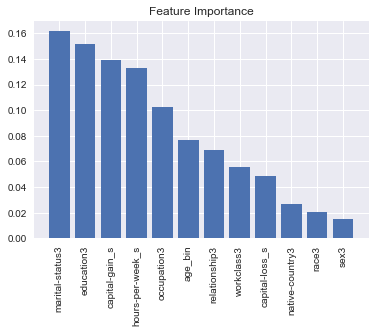

In [32]:
#calculate feature importances
importances = modelRF.feature_importances_
#sort feature importances in descending order
indices = np.argsort(importances)[::-1]
names = [x.columns[i] for i in indices]
#create plot
plt.figure()
#create plot title
plt.title("Feature Importance")
#add bars
plt.bar(range(X_test.shape[1]), importances[indices])
#add feature names as x-axis labels
plt.xticks(range(X_test.shape[1]), names, rotation=90)
#show plot
plt.show()

In [33]:
#hyperparameter tuning
#random Hyperparameter Grid
#number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#number of features to consider at every split
max_features = ['auto', 'sqrt']
#maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#method of selecting samples for training each tree
bootstrap = [True, False]
#create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
#use the random grid to search for best hyperparameters
#first create the base model to tune
rf = RandomForestClassifier()
#random search of parameters, using 3 fold cross validation, 
#search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#fit the random search model
rf_random.fit(X_train,y_train)
print(rf_random.best_params_)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.9min finished


{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [34]:
#create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1400,1600,1800]
}
#instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)
#fit the grid search to the data
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
print(best_grid)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 24.2min finished


{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 1600}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [35]:
#use tuned parameters for final model
modelRFf = (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False))
modelRFf.fit(X_train,y_train)
y_predictRFf = modelRFf.predict(X_test)
print(confusion_matrix(y_test, y_predictRFf))
print(accuracy_score(y_test, y_predictRFf, normalize=True))

[[6390  361]
 [ 833 1323]]
0.8659481306837319


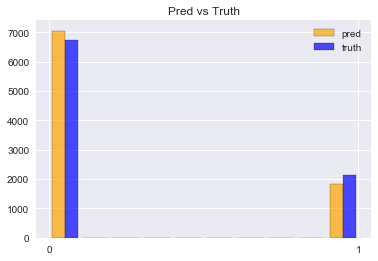

In [36]:
#visualization of final predicted results
df1 = pd.DataFrame(y_predictRF, columns = ['pred'], index=None)
df2 = pd.DataFrame(y_test, columns = ['truth'], index=None)
df3 = pd.concat([df1,df2], axis=1, sort='False')
colors = ['orange', 'blue']
fig1, ax8 = plt.subplots()
ax8.set_title('Pred vs Truth')
ax8.hist(df3, alpha=0.7, rwidth=0.85,edgecolor="k",color=colors)
plt.legend(labels=['pred', 'truth'],loc='upper right')
plt.show()